# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [2]:
pip install torch -q

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('YearPredictionMSD.txt')
df.head()

,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
0,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
1,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
2,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
3,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
4,2001,50.54767,0.31568,92.35066,22.38696,-25.51870,-19.04928,20.67345,-5.19943,3.63566,...,6.59753,-50.69577,26.02574,18.94430,-0.33730,6.09352,35.18381,5.00283,-11.02257,0.02263


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [3]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [175]:
df.describe()

,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
count,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,...,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000
mean,1998.397077,43.387113,1.289515,8.658222,1.164110,-6.553580,-9.521968,-2.391046,-1.793215,3.727868,...,15.755411,-73.461537,41.542388,37.934163,0.315750,17.669292,-26.315520,4.458653,20.035229,1.329104
std,10.931056,6.067557,51.580393,35.268505,16.322802,22.860803,12.857763,14.571853,7.963822,10.582869,...,32.099666,175.619058,122.228915,95.050718,16.161780,114.428002,173.977455,13.346567,185.558415,22.088598
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954667,-26.059848,-11.462775,-8.487507,-20.666455,-18.441005,-10.780360,-6.468390,-2.293670,...,-1.812658,-139.555737,-20.987115,-4.669655,-6.781598,-31.580617,-101.530305,-2.566137,-59.509453,-8.820248
50%,2002.000000,44.258490,8.417725,10.476235,-0.652855,-6.007770,-11.188355,-2.046625,-1.736415,3.822305,...,9.171850,-53.089115,28.790580,33.623815,0.820830,15.598520,-21.204225,3.117645,7.759910,0.053015
75%,2006.000000,47.833875,36.124030,29.764685,8.787548,7.741877,-2.388945,6.508587,2.913455,9.961865,...,26.274487,13.478793,89.661785,77.785810,8.471000,67.795110,52.389322,9.967742,86.351645,9.679540
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


In [176]:
df.isnull().sum().sum()

0

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [5]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [6]:
set_random_seed(42)

In [7]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [181]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
rmse_for_model = np.sqrt(np.mean((y_pred-y_test)**2))
rmse_for_model

9.510102474328402

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [182]:
const= y_train.mean()
y_pred=np.full(shape=(y_test.shape),fill_value=const)
rmse_for_const = np.sqrt(np.mean((y_pred-y_test)**2))
rmse_for_const

10.852502661251654

In [183]:
best_rmse_metric = rmse_for_model

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [8]:
w=torch.rand(X.shape[1],1,requires_grad=True)
b=torch.rand(1,requires_grad=True)

X_train_t=torch.tensor(X_train,dtype=torch.float32)
y_train_t=torch.tensor(y_train,dtype=torch.float32)
y_train_t=y_train_t.reshape(-1,1)

X_test_t=torch.tensor(X_test,dtype=torch.float32)
y_test_t=torch.tensor(y_test,dtype=torch.float32)
y_test_t=y_test_t.reshape(-1,1)

***Без мини батч***

In [185]:
def rmse(y_pred,y_test):
    return torch.sqrt(torch.mean((y_pred-y_test)**2))
    

In [186]:
i=0
while i <1000:
    
    # previous_rmse=rmse(y_pred,y_train_t)
    y_pred=b+X_train_t@w
    loss=rmse(y_pred,y_train_t)
    loss.backward()

    w.data=w.data-0.05*w.grad
    b.data=b.data-0.05*b.grad
    
    w.grad.data.zero_()
    b.grad.data.zero_()
    i+=1
    
rmse(y_pred,y_train_t)

tensor(1947.8748, grad_fn=<SqrtBackward0>)

***Мини батч***

In [9]:
from torch.utils.data import DataLoader, TensorDataset

In [10]:
train_dataset=TensorDataset(X_train_t,y_train_t)
test_dataset=TensorDataset(X_test_t,y_test_t)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=50, shuffle=True, num_workers=1
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=50, shuffle=True, num_workers=1
)

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

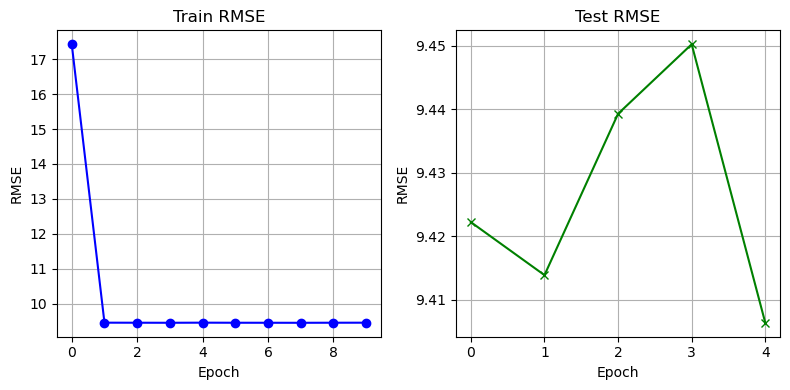

Epochs: 100%|██████████| 10/10 [00:52<00:00,  5.25s/it]


In [192]:
from tqdm import tqdm

epochs=10
train_loss_history = []
test_loss_history = []

for epo in tqdm(range(epochs), desc="Epochs"):
    train_losses=[]
    for X_train,y_train in train_dataloader:
        y_pred=b+X_train@w
        loss=rmse(y_pred,y_train)
        loss.backward()
        
        w.data=w.data-0.05*w.grad
        b.data=b.data-0.05*b.grad
        
        w.grad.data.zero_()
        b.grad.data.zero_()
        train_losses.append(loss.item())
    avg_train_loss = np.mean(train_losses)
    train_loss_history.append(avg_train_loss)
        
        

    if epo %2 ==0:
            test_losses=[]
            with torch.no_grad():
                for X_test,y_test in test_dataloader:
                    y_pred_test=b+X_test@w
                    test_score=rmse(y_pred_test,y_test)
                    test_losses.append(test_score.item())
                
                    
                test_losses_avg=np.mean(test_losses)
                test_loss_history.append(test_losses_avg)

                print(        
                f"Epoch: {epo}, loss: {test_losses_avg}"
            )
    clear_output(wait=True)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].plot(train_loss_history, label="Train RMSE", color="blue", marker="o")
    axs[0].set_title("Train RMSE")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("RMSE")
    axs[0].grid(True)

    axs[1].plot(test_loss_history, label="Test RMSE", color="green", marker="x")
    axs[1].set_title("Test RMSE")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("RMSE")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()
    
    
                    

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
from torch.optim.lr_scheduler import StepLR

In [37]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
train_set = None 
train_loader = None 

test_set = None  
test_loader = None  

model = None
optimizer = None  
criterion = None

In [93]:
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    epochs=30
    test_history=[]
    test_score_avg=0
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
    for epo in range (epochs):
        
        for  X_train,y_train in train_loader:
            y_pred=model(X_train)
            loss=criterion(y_pred,y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        scheduler.step()
            
        if (epo %2==0) and (epo!=0):
            
            with torch.no_grad():
                test_score=[]
                for X_test,y_test in test_loader:
                     y_pred_test=model(X_test)
                     loss=criterion(y_pred_test,y_test)
                     test_score.append(loss.item())

                test_score_avg=np.mean(test_score)
                test_history.append(test_score_avg)
    
        clear_output(wait=True)
        plt.figure(figsize=(8,4))
        plt.plot(test_history)
        plt.title(f'RMSE Test Valuation:{test_score_avg}')
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.grid()
        plt.show()
    return model
    


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
       
   # with torch.no_grad():
    test_score=[]
    for X_test,y_test in test_loader:
             y_pred_test=model(X_test)
             loss=criterion(y_pred_test,y_test)
             test_score.append(loss.item())
    test_score_avg=np.mean(test_score)
    print(f'RMSE: {test_score_avg}')
    predicts = torch.ones(len(test_loader.dataset))
    return predicts


In [14]:
class RMSE (nn.Module):
      def __init__(self):
          super().__init__()
      def forward(self,y_pred,y_fact):
          return torch.sqrt(torch.mean((y_pred - y_fact)**2))
        

In [82]:
model= nn.Sequential(
    nn.Linear(X.shape[1],X.shape[1]//2),
    nn.ReLU(),
    nn.Linear(X.shape[1]//2,X.shape[1]//4),
    nn.ReLU(),
    nn.Linear(X.shape[1]//4,X.shape[1]//8),
    nn.ReLU(),
    nn.Linear(X.shape[1]//8,1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = RMSE()

In [38]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


X_train_t=torch.tensor(X_train,dtype=torch.float32)
y_train_t=torch.tensor(y_train,dtype=torch.float32)
y_train_t=y_train_t.reshape(-1,1)

X_test_t=torch.tensor(X_test,dtype=torch.float32)
y_test_t=torch.tensor(y_test,dtype=torch.float32)
y_test_t=y_test_t.reshape(-1,1)

In [76]:
train_dataset=TensorDataset(X_train_t,y_train_t)
test_dataset=TensorDataset(X_test_t,y_test_t)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=24, shuffle=True, num_workers=1
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=24, shuffle=True, num_workers=1
)

In [86]:
set_random_seed(42)

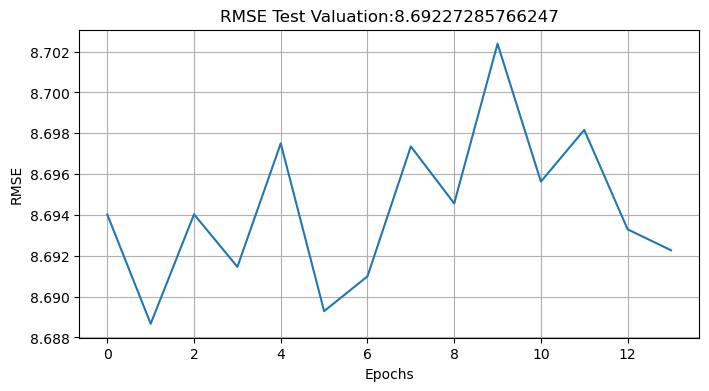

In [88]:
new_model=train(model, optimizer, criterion, train_dataloader, test_dataloader)

In [94]:
test(new_model, criterion, test_dataloader)

RMSE: 8.68550703993074


tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [ ]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Поигрался с кол-вом слоев в модели, в основном  выходы уменьшал в степенной мере, также попробовал разные размеры мини батчей и разные виды оптимизаторов.
 Применил уменьшающийся learning rate